### Build minimum spanning tree  
1. Calculate the correlation matrix of price change
2. Obtain the edge list by Prim's algorithm of minimum spanning tree
3. Creat the Graph object by networkingx  

### Schematising of Minimum Spanning Tree:
1. rank a couple of vertices(stocks) from the nearest to the farthest  
2. draw the first edge from this rank  
3. continue in the rank  
4. if the new edge does not close a cycle draw it  
5. go to point 3  
6. stop when all the vertices have been drawn  

Reference:  
https://mktstk.com/2015/03/04/stock-market-visualization-minimum-spanning-trees/  
http://peekaboo-vision.blogspot.com/2012/02/simplistic-minimum-spanning-tree-in.html  

In [290]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Prim's algotithm to get edge list by minimum spanning trees
def minimum_spanning_tree(X, copy_X=True):
    """X are edge weights of fully connected graph"""
    if copy_X:
        X = X.copy()
 
    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []
     
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
     
    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                      
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                       
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    return np.vstack(spanning_edges)

In [16]:
years = [str(y) for y in range(2008, 2017)]
for year in years:
    # Read in correlation matrix
    corr = pd.read_csv('corr_' + year +'.csv', index_col=0)
    # Calculate the distance between pairwise stocks
    # distance[i, j] = sqrt(2.0 * ( 1 – correlation[i, j] ) )
    dist = np.sqrt(2*(1- corr)) 
    #dist.to_csv('dist_2016.csv')
    # Get edges
    dist = np.array(dist)
    edge_list_raw = minimum_spanning_tree(dist)
    edge_list = []
    for i, j in edge_list_raw:
        edge = (corr.columns.values[i], corr.columns.values[j])
        edge_list.append(edge)

    # Export edges
    #edges = pd.DataFrame(edge_list)
    #edges.to_csv('edges_2016.csv')
    
    # Create graph object by adding edges
    mst = nx.Graph()
    for i, j in edge_list:
        mst.add_edge(i,j)
    
    # Export network for further use in Gephi
    nx.write_gexf(mst, 'mst_' + year + '.gexf')

### Portfolio Selection Based on MST 
#### Measurements of centrality and peripherality

(I) Degree K, the number of neighbor nodes connected to a node. The larger the K is, the more the edges that are associated with this node.

(II) Betweenness centrality C, reflecting the contribution of a node to the connectivity of the network. Denote V as the set of nodes in the network.  

Distance refers to the shortest length from a node to the central node of the network. Here, three types of definitions of a central node are introduced to reduce the error caused by a single method. Therefore three types of distances are described here.  

(III) Distance on degree criterion Ddegree, a central node is the node that has the largest degree.

(IV) Distance on correlation criterion Dcorrelation, a central node is the node with the highest value of the sum of correlation coefficients with its neighbors;

(V) Distance on distance criterion Ddistance, a central node is the node that gives the smallest value for the mean distance.  

Then we have two simple index to measure centrality and peripherality.  
$Centrality\ index = 0.5*Degree + 0.5*Betweenness\ centrality$  
$Distance\ index = \frac{Ddegree + Dcorrelation + Ddistance}{3}$


#### Portfolio Selection  

Central portfolio: stocks with the first 15 largest centrality index   
Peripheral portfolio: stocks with the first 15 largest distance index  


The central portfolios and the peripheral portfolios represent two opposite sides of correlation and agglomeration. Generally speaking, central stocks play a vital role in the market and impose strong influence on other stocks, whereas the correlations between peripheral stocks are weak and contain more noise than central stocks.

Reference:  
http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169299

In [99]:
corr = pd.read_csv('corr_2015.csv', index_col = 0)
g = nx.read_gexf('mst_2015.gexf')
d = nx.degree(g)
b_c = nx.betweenness_centrality(g)

In [122]:
# Distance on degree criterion
D_dg = {}

# central node with the largest degree
c1 = max(d, key=d.get)
for n in g.nodes():
    D_dg[n] = nx.shortest_path_length(g, n, c1)

In [70]:
# Distance on correlation criterion
D_c = {}
sum_C = {}

# central node with the highest value of the sum of correlation coefficients with its neighbors
for n in g.nodes():
    nbs = nx.neighbors(g, n)
    sum_C[n] = sum(corr[n][nb] for nb in nbs)
c2 = max(sum_C, key=sum_C.get)

for n in g.nodes():
    D_c[n] = nx.shortest_path_length(g, n, c2)

In [95]:
# Distance on distance criterion
D_d = {}
m_d = {}

# central node with the smallest mean distance
for n in g.nodes():
    nodes = g.nodes()
    nodes.remove(n) 
    dd = [nx.shortest_path_length(g, n, ns) for ns in nodes]
    m_d[n] = np.mean(dd)

c3 = min(m_d, key=m_d.get)

for n in g.nodes():
    D_d[n] = nx.shortest_path_length(g, n, c3)

In [131]:
nodes_stats = pd.DataFrame.from_dict(d, orient='index')
nodes_stats.rename(columns={0:'Degree'}, inplace=True)
nodes_stats['Betweenness'] = b_c.values()
nodes_stats['Centrality'] = .5*(nodes_stats['Degree'] + nodes_stats['Betweenness'])
nodes_stats['Ddegree'] = D_dg.values()
nodes_stats['Dcorr'] = D_c.values()
nodes_stats['Ddis'] = D_d.values()
nodes_stats['Distance'] = (nodes_stats['Ddegree'] + nodes_stats['Dcorr'] + nodes_stats['Ddis'])/3
nodes_stats.head()

,Degree,Betweenness,Centrality,Ddegree,Dcorr,Ddis,Distance
AGN,3,0.007976,1.503988,4,4,6,4.666667
EOG,3,0.019832,1.509916,11,11,9,10.333333
CPB,2,0.058204,1.029102,6,6,4,5.333333
EVHC,1,0.000000,0.500000,8,8,6,7.333333
IDXX,1,0.000000,0.500000,6,6,4,5.333333


In [284]:
# Central Portfolio
c = nodes_stats.sort_values(by='Centrality', ascending = False).head(15)
portfolio_c = [name for name in c.index.values]
print portfolio_c
for n in portfolio_c:
    g.node[n]['portfolio'] = 'C'

['FISV', 'ITW', 'MMC', 'HD', 'DTE', 'TMO', 'HON', 'ABT', 'LLTC', 'AMGN', 'BRK-B', 'CINF', 'HSIC', 'COP', 'REG']


In [286]:
# Peripheral Portfolio
p = nodes_stats.sort_values(by='Distance', ascending = False).head(15)
portfolio_p = [name for name in p.index.values]
print portfolio_p
for n in portfolio_p:
    g.node[n]['portfolio'] = 'P'
    
nx.write_gexf(g, 'mst_2015_portfolio.gexf')

['COG', 'EQT', 'RRC', 'CSRA', 'TSO', 'VLO', 'SWN', 'NFX', 'PXD', 'FTI', 'APC', 'CXO', 'CHK', 'APA', 'RIG']


In [257]:
return_2016 = pd.read_csv('change_2016.csv', index_col = 0)
price_2016 = pd.read_csv('price_2016.csv', index_col = 0)

In [210]:
# check data completeness
print [s in return_2016.columns.values for s in portfolio_c]
print [s in return_2016.columns.values for s in portfolio_p]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [197]:
from yahoo_finance import Share
reg = Share('REG')
df_reg = pd.DataFrame(reg.get_historical('2016-1-1', '2016-12-31'))
df_reg.index = df_reg['Date']

In [229]:
close_reg = df_reg['Adj_Close']
price_reg = [float(p) for p in close_reg]

In [267]:
def portfolio_value(amount, portfolio_list):
    """
    Return the value of portfolio invested.
    Inputs:
    amount(number): investment amount
    portfolio_list(list): components of portfolio"""
    portfolio_price = pd.DataFrame()
    for c in portfolio_list:
        try:
            portfolio_price[c] = price_2016[c]
        except KeyError:
            portfolio_price[c] = price_reg
    portfolio_unit = portfolio_price.sum(axis=1)[0]
    share = amount/portfolio_unit
    portfolio_value = portfolio_price.sum(axis=1)*share
    return portfolio_value

In [235]:
sp500_2016 = pd.read_csv('sp500_2016.csv')
price_sp500 = sp500_2016['Adjusted Close']

In [271]:
# Assume invest $100000 on the portfolio on 2016-01-01 and keep the portfolio for 1 year
central_portfolio_value = portfolio_value(100000, portfolio_c)
peripheral_portfolio_value = portfolio_value(100000, portfolio_p)
# compare with marcket performance
sp500_value = price_sp500 * (100000/price_sp500[0])

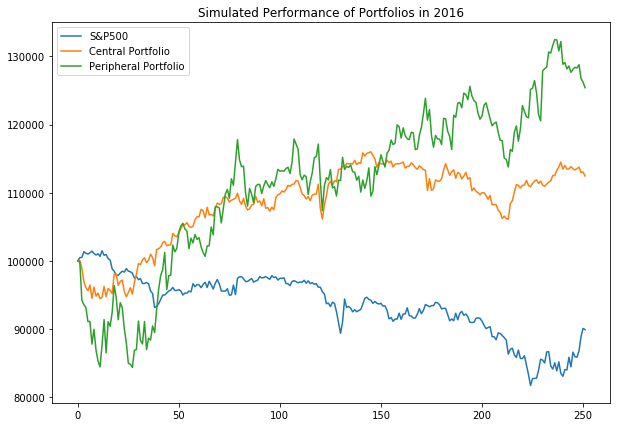

In [296]:
x = range(252)
fig, ax = plt.subplots(figsize = (10,7))
line1, = ax.plot(x, sp500_value, label='S&P500')
line2, = ax.plot(x, central_portfolio_value, label='Central Portfolio')
line3, = ax.plot(x, peripheral_portfolio_value, label = 'Peripheral Portfolio' )
ax.set_title('Simulated Performance of Portfolios in 2016')
ax.legend(loc='upper left')
plt.savefig('performance of portfolio.png')
plt.show()